# Tables creation

### Import libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

### Data path and DB connection

In [2]:
DATA_PATH = '../data/'

In [3]:
conn = sqlite3.connect(DATA_PATH + 'technicalDebtDataset.db')

### Fetch main tables

In [4]:
query = ''' SELECT
                gc.projectID, gc.commitHash, gc.commitMessage,
                sm.complexity, sm.lines, sm.commentLines, sm.duplicatedLines,
                sm.violations, sm.blockerViolations, sm.criticalViolations, sm.majorViolations, sm.minorViolations,
                sm.bugs, sm.codeSmells 
            FROM
                GIT_COMMITS as gc
            INNER JOIN
                SONAR_MEASURES as sm
            WHERE
                gc.commitHash = sm.commitHash
'''

### Show dataframe

In [5]:
df = pd.read_sql_query(query, conn)
df.head()

,projectID,commitHash,commitMessage,complexity,lines,commentLines,duplicatedLines,violations,blockerViolations,criticalViolations,majorViolations,minorViolations,bugs,codeSmells
0,accumulo,e0880e263e4bf8662ba3848405200473a25dfc9f,ACCUMULO-1 initial checkin of source code\n\ng...,43137,263680,13509,46445,18314,142,893,7310,9889,464,17012
1,accumulo,e8774c5ec3a35e042f320540b5f7e66ebd2d9e87,"ACCUMULO-2 moved cloudtrace for TRUNK, fixed p...",43137,262753,13507,46301,18169,142,893,7164,9890,344,16987
2,accumulo,2032ebbd0ed90734da39ca238bbd10dee24d0030,ACCUMULO-2 fixed thrift build script to point ...,43137,262753,13507,46301,18169,142,893,7164,9890,344,16987
3,accumulo,de297d4932e08625a5df146f0802041bb5aeb892,ACCUMULO-2 reverted change to config.html\n\ng...,43137,263643,13507,46445,18315,142,893,7310,9890,464,17013
4,accumulo,34efaae87639a83b60fdb7274de4b45051025a3a,ACCUMULO-2 fixed cloudtrace references in cont...,43137,263639,13507,46445,18315,142,893,7310,9890,464,17013


### Convert some columns to numeric

In [6]:
cols = [i for i in df.columns if i not in ['projectID','commitHash','commitMessage']]
for col in cols:
    df[col] = df[col].astype(int)

In [7]:
df.dtypes

projectID             object
commitHash            object
commitMessage         object
complexity             int64
lines                  int64
commentLines           int64
duplicatedLines        int64
violations             int64
blockerViolations      int64
criticalViolations     int64
majorViolations        int64
minorViolations        int64
bugs                   int64
codeSmells             int64
dtype: object

### Columns metrics

In [8]:
df.describe()

,complexity,lines,commentLines,duplicatedLines,violations,blockerViolations,criticalViolations,majorViolations,minorViolations,bugs,codeSmells
count,55629.000000,5.562900e+04,55629.000000,55629.000000,55629.000000,55629.000000,55629.000000,55629.000000,55629.000000,55629.000000,55629.000000
mean,12112.140179,1.327941e+05,17577.502921,15517.791602,5440.302198,27.425030,373.338097,2375.444157,2563.342861,74.626670,5235.007442
std,15175.782233,1.515171e+05,18922.274369,24901.111445,6642.833830,53.010832,355.199801,2700.680993,3778.729807,113.049746,6368.548284
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2522.000000,2.941900e+04,4205.000000,2048.000000,1197.000000,2.000000,85.000000,498.000000,397.000000,6.000000,1168.000000
50%,5302.000000,6.624600e+04,10221.000000,6113.000000,2291.000000,8.000000,240.000000,1050.000000,899.000000,19.000000,2163.000000
75%,14080.000000,1.663610e+05,22674.000000,19504.000000,9358.000000,38.000000,626.000000,3188.000000,4050.000000,112.000000,9018.000000
max,139214.000000,1.175349e+06,125220.000000,264993.000000,48093.000000,419.000000,1305.000000,24772.000000,21509.000000,1505.000000,45538.000000


### Preprocessing on "violations" types

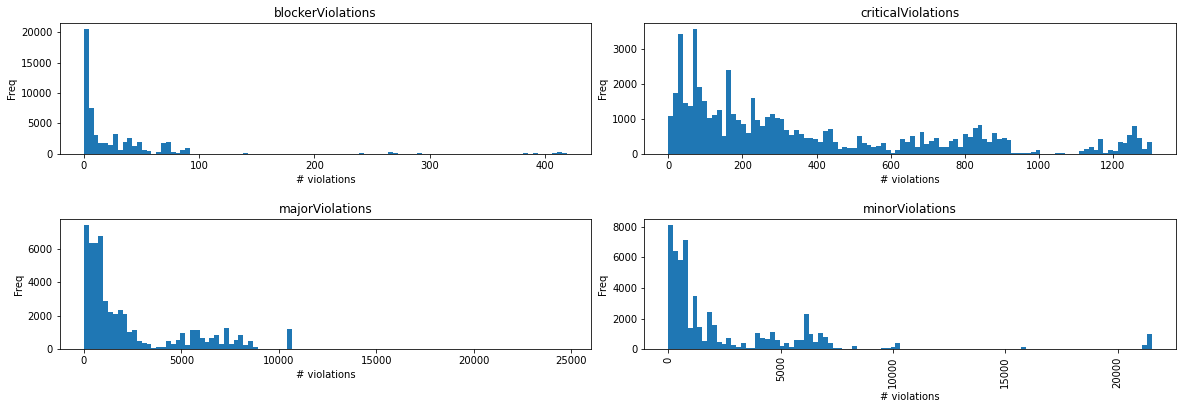

In [9]:
fig , ax = plt.subplots(2,2, figsize=(20,6))
plt.subplots_adjust(wspace=0.1, hspace=0.5)
ax[0,0].hist(df['blockerViolations'], bins=100)
ax[0,1].hist(df['criticalViolations'], bins=100)
ax[1,0].hist(df['majorViolations'], bins=100)
ax[1,1].hist(df['minorViolations'], bins=100)

ax[0,0].title.set_text('blockerViolations')
ax[0,0].set_ylabel('Freq')
ax[0,0].set_xlabel('# violations')
ax[0,1].title.set_text('criticalViolations')
ax[0,1].set_ylabel('Freq')
ax[0,1].set_xlabel('# violations')
ax[1,0].title.set_text('majorViolations')
ax[1,0].set_xlabel('# violations')
ax[1,0].set_ylabel('Freq')
ax[1,1].title.set_text('minorViolations')
ax[1,1].set_xlabel('# violations')
ax[1,1].set_ylabel('Freq')
plt.xticks(rotation='vertical')
plt.show()

Cut violations only where there is data.

In [10]:
df['blockerViolations'] = df['blockerViolations'].where(df['blockerViolations'] <= 100, 100)
df['majorViolations'] = df['majorViolations'].where(df['majorViolations'] <= 10000, 10000)
df['minorViolations'] = df['minorViolations'].where(df['minorViolations'] <= 10000, 10000)

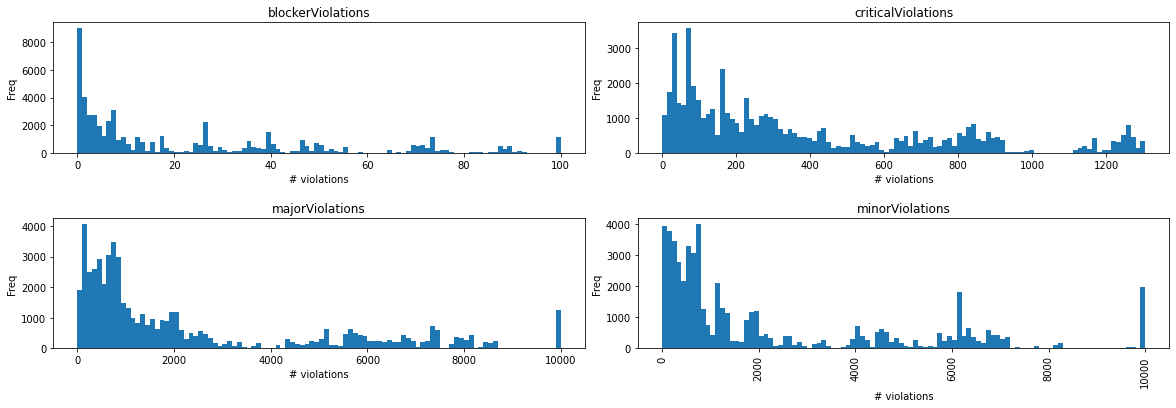

In [11]:
fig , ax = plt.subplots(2,2, figsize=(20,6))
plt.subplots_adjust(wspace=0.1, hspace=0.5)
ax[0,0].hist(df['blockerViolations'], bins=100)
ax[0,1].hist(df['criticalViolations'], bins=100)
ax[1,0].hist(df['majorViolations'], bins=100)
ax[1,1].hist(df['minorViolations'], bins=100)

ax[0,0].title.set_text('blockerViolations')
ax[0,0].set_ylabel('Freq')
ax[0,0].set_xlabel('# violations')
ax[0,1].title.set_text('criticalViolations')
ax[0,1].set_ylabel('Freq')
ax[0,1].set_xlabel('# violations')
ax[1,0].title.set_text('majorViolations')
ax[1,0].set_xlabel('# violations')
ax[1,0].set_ylabel('Freq')
ax[1,1].title.set_text('minorViolations')
ax[1,1].set_xlabel('# violations')
ax[1,1].set_ylabel('Freq')
plt.xticks(rotation='vertical')
plt.show()

We merge minor and major violations into one, by adding them up.

In [12]:
df = df.assign(mimaViolations = df['minorViolations'] + df['majorViolations'])

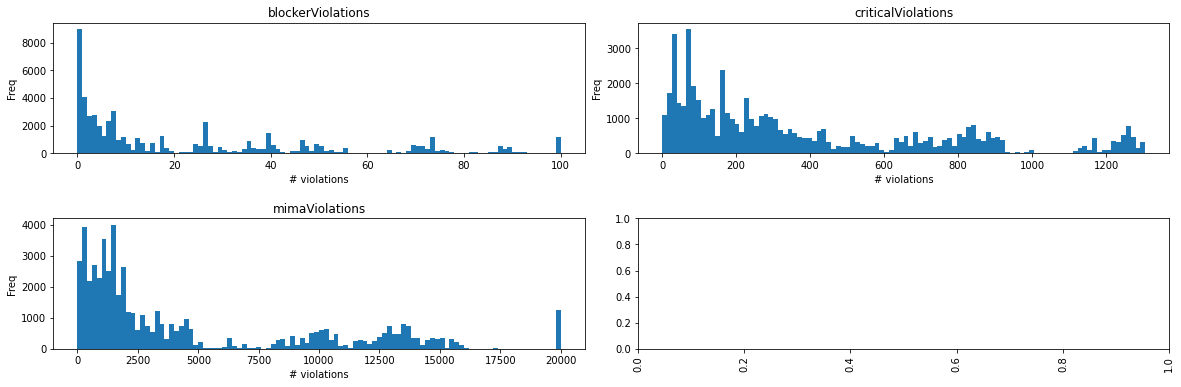

In [13]:
fig , ax = plt.subplots(2,2, figsize=(20,6))
plt.subplots_adjust(wspace=0.1, hspace=0.5)

ax[0,0].hist(df['blockerViolations'], bins=100)
ax[0,1].hist(df['criticalViolations'], bins=100)
ax[1,0].hist(df['mimaViolations'], bins=100)

ax[0,0].title.set_text('blockerViolations')
ax[0,0].set_ylabel('Freq')
ax[0,0].set_xlabel('# violations')
ax[0,1].title.set_text('criticalViolations')
ax[0,1].set_ylabel('Freq')
ax[0,1].set_xlabel('# violations')
ax[1,0].title.set_text('mimaViolations')
ax[1,0].set_xlabel('# violations')
ax[1,0].set_ylabel('Freq')
plt.xticks(rotation='vertical')
plt.show()

Create bins for different groups.

In [14]:
# Partition by steps, intervals of the same size
def categorize_1(N_BINS, v):
    bins = np.arange(min(v), max(v)+1, step = max(v)//N_BINS)
    bins[-1] += 1
    bins[0] = -1
    return bins

# Partition according to the distribution of the data, 
# same number of items in each interval
def categorize_2(N_BINS, v):
    v = v.sort_values()
    n = len(v)
    id_seps = [int(i*n/N_BINS) for i in range(0,N_BINS+1)]
    seps = [v.iloc[el-1] for el in id_seps]
    seps[0] = v.iloc[0]-1
    return seps

In [15]:
v = df.blockerViolations
n_groups = 3

categorize_2(n_groups, v)

[-1, 4, 26, 100]

In [16]:
v = df.blockerViolations
n_groups = 3

categorize_1(n_groups, v)

array([ -1,  33,  66, 100])

Create interval variables for each violation.

In [17]:
n_groups = 2

In [18]:
df['bin_blockerViolations'] = pd.cut(df['blockerViolations'], categorize_2(n_groups, df['blockerViolations']))
df['bin_criticalViolations'] = pd.cut(df['criticalViolations'], categorize_2(n_groups, df['criticalViolations']))
df['bin_mimaViolations'] = pd.cut(df['mimaViolations'], categorize_2(n_groups, df['mimaViolations']))

In [19]:
df['class_blockerViolations'] = df['bin_blockerViolations'].cat.codes.astype(str)
df['class_criticalViolations'] = df['bin_criticalViolations'].cat.codes.astype(str)
df['class_mimaViolations'] = df['bin_mimaViolations'].cat.codes.astype(str)

Merge them all and create a colum paste of all combination of classes.

In [20]:
df["class"] = df["class_blockerViolations"] + df["class_criticalViolations"] + df["class_mimaViolations"]
df['class']

0        111
1        111
2        111
3        111
4        111
        ... 
55624    111
55625    111
55626    111
55627    111
55628    111
Name: class, Length: 55629, dtype: object

Assign a category to each combination of class.

In [21]:
df['class'] = df['class'].astype('category')
df['category'] = df['class'].cat.codes
df[['class','category']]

,class,category
0,111,7
1,111,7
2,111,7
3,111,7
4,111,7
...,...,...
55624,111,7
55625,111,7
55626,111,7
55627,111,7


We get the combination categories below.

In [22]:
print(sorted(df['class'].unique()))

['000', '001', '010', '011', '100', '101', '110', '111']


Category codification into integers

In [23]:
print(sorted(df['category'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7]


Check if there are NA categories.

In [24]:
df[df.category.isna()]

,projectID,commitHash,commitMessage,complexity,lines,commentLines,duplicatedLines,violations,blockerViolations,criticalViolations,...,codeSmells,mimaViolations,bin_blockerViolations,bin_criticalViolations,bin_mimaViolations,class_blockerViolations,class_criticalViolations,class_mimaViolations,class,category


We create a lookup table of the data created (in order to check which intervals where chosen, if needed)

In [25]:
viols = ['bin_blockerViolations','bin_criticalViolations','bin_mimaViolations']
categories = pd.DataFrame()
for v in viols:
    t = pd.DataFrame({'interval': df[v].unique()})
    t['type'] = v
    t['class'] = np.arange(0,len(df[v].unique()))
    categories = pd.concat([categories,t])
categories.reset_index(drop=True)

,interval,type,class
0,"(8, 100]",bin_blockerViolations,0
1,"(-1, 8]",bin_blockerViolations,1
2,"(240, 1305]",bin_criticalViolations,0
3,"(-1, 240]",bin_criticalViolations,1
4,"(1963, 20000]",bin_mimaViolations,0
5,"(-1, 1963]",bin_mimaViolations,1


### Resulting table

In [26]:
df

,projectID,commitHash,commitMessage,complexity,lines,commentLines,duplicatedLines,violations,blockerViolations,criticalViolations,...,codeSmells,mimaViolations,bin_blockerViolations,bin_criticalViolations,bin_mimaViolations,class_blockerViolations,class_criticalViolations,class_mimaViolations,class,category
0,accumulo,e0880e263e4bf8662ba3848405200473a25dfc9f,ACCUMULO-1 initial checkin of source code\n\ng...,43137,263680,13509,46445,18314,100,893,...,17012,17199,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
1,accumulo,e8774c5ec3a35e042f320540b5f7e66ebd2d9e87,"ACCUMULO-2 moved cloudtrace for TRUNK, fixed p...",43137,262753,13507,46301,18169,100,893,...,16987,17054,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
2,accumulo,2032ebbd0ed90734da39ca238bbd10dee24d0030,ACCUMULO-2 fixed thrift build script to point ...,43137,262753,13507,46301,18169,100,893,...,16987,17054,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
3,accumulo,de297d4932e08625a5df146f0802041bb5aeb892,ACCUMULO-2 reverted change to config.html\n\ng...,43137,263643,13507,46445,18315,100,893,...,17013,17200,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
4,accumulo,34efaae87639a83b60fdb7274de4b45051025a3a,ACCUMULO-2 fixed cloudtrace references in cont...,43137,263639,13507,46445,18315,100,893,...,17013,17200,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55624,zookeeper,cd0e323831c8b4cde64976325bfc79bb53cdd9b7,ZOOKEEPER-2635: Regenerate documentation (fpj),10111,103678,10708,5142,4981,18,534,...,4471,4352,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
55625,zookeeper,482ce218d815b7a613ed9728b82602ddecc61996,ZOOKEEPER-761: Remove *synchronous* calls from...,10111,103678,10708,5142,4981,18,534,...,4471,4352,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
55626,zookeeper,dfcf4da75c35c12d08496ded2612031f887c0765,ZOOKEEPER-2647: Fix TestReconfigServer.cc\n\nA...,10111,103678,10708,5142,4981,18,534,...,4471,4352,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
55627,zookeeper,8616a9ec8ce4bc8ac2987b7417a6f0c4b7333658,ZOOKEEPER-2479: Add 'electionTimeTaken' value ...,10118,103746,10715,5142,4981,18,534,...,4471,4352,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7


Number of instances for each category

In [27]:
df['category'].value_counts(), df['category'].count(), 

(7    19000
 0    18759
 4     3933
 3     3621
 2     3140
 5     2731
 1     2442
 6     2003
 Name: category, dtype: int64,
 55629)

Category distribution plot

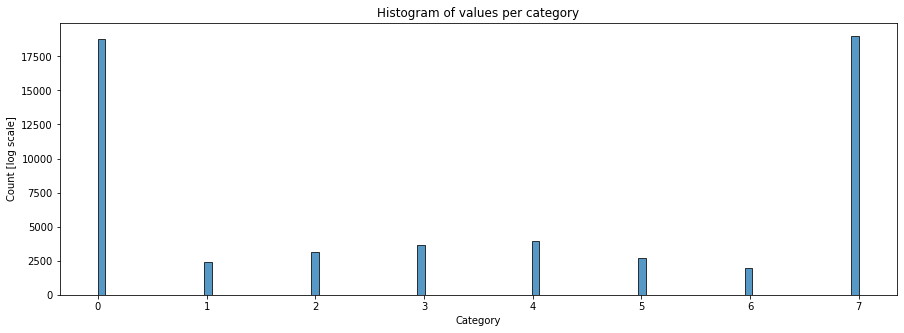

In [28]:
import seaborn as sns
fig , ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(df['category'], bins=100, ax =ax)
ax.set_xticks(df.category.unique())
ax.set_xlabel("Category")
ax.set_ylabel("Count [log scale]")
ax.set_title('Histogram of values per category')
#ax.set_yscale('log')
plt.show()

### Save table data

Save it as pickle.

In [29]:
SAVE_PATH = '../data/our_data/'

In [30]:
filename = 'commits_violations_8.pkl'

df.to_pickle(SAVE_PATH + filename)

We can read it by using:

In [31]:
df = pd.read_pickle(SAVE_PATH + filename)
df.head()

,projectID,commitHash,commitMessage,complexity,lines,commentLines,duplicatedLines,violations,blockerViolations,criticalViolations,...,codeSmells,mimaViolations,bin_blockerViolations,bin_criticalViolations,bin_mimaViolations,class_blockerViolations,class_criticalViolations,class_mimaViolations,class,category
0,accumulo,e0880e263e4bf8662ba3848405200473a25dfc9f,ACCUMULO-1 initial checkin of source code\n\ng...,43137,263680,13509,46445,18314,100,893,...,17012,17199,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
1,accumulo,e8774c5ec3a35e042f320540b5f7e66ebd2d9e87,"ACCUMULO-2 moved cloudtrace for TRUNK, fixed p...",43137,262753,13507,46301,18169,100,893,...,16987,17054,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
2,accumulo,2032ebbd0ed90734da39ca238bbd10dee24d0030,ACCUMULO-2 fixed thrift build script to point ...,43137,262753,13507,46301,18169,100,893,...,16987,17054,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
3,accumulo,de297d4932e08625a5df146f0802041bb5aeb892,ACCUMULO-2 reverted change to config.html\n\ng...,43137,263643,13507,46445,18315,100,893,...,17013,17200,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7
4,accumulo,34efaae87639a83b60fdb7274de4b45051025a3a,ACCUMULO-2 fixed cloudtrace references in cont...,43137,263639,13507,46445,18315,100,893,...,17013,17200,"(8, 100]","(240, 1305]","(1963, 20000]",1,1,1,111,7


### Pearson Correlation of Features

In [32]:
dff = df[['complexity', 'lines', 'commentLines', 'duplicatedLines', 'violations','category']]

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

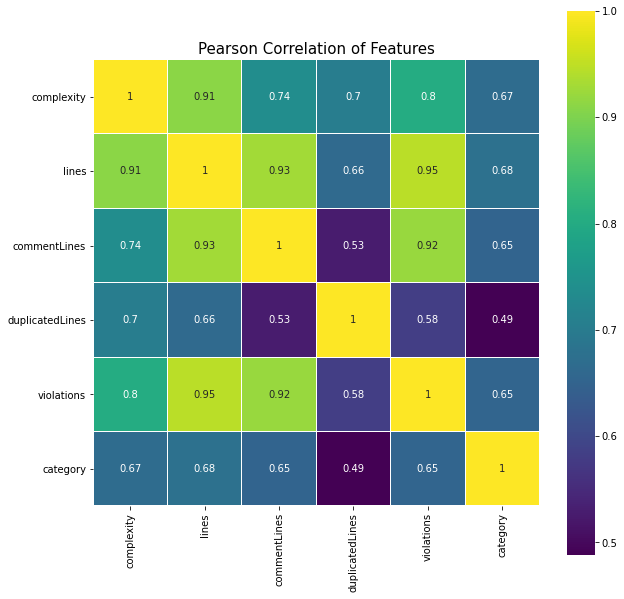

In [33]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size=15)

sns.heatmap(dff.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### PCA

In [71]:
X = df[['lines', 'commentLines', 'duplicatedLines', 'category']]
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)

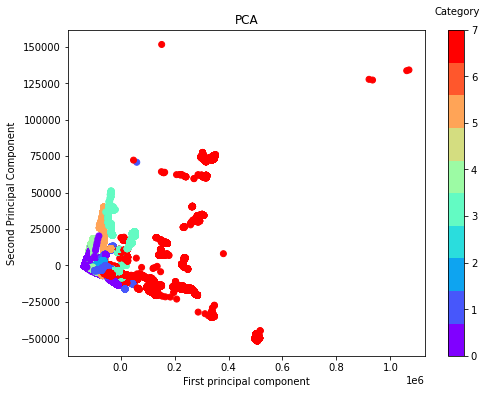

In [72]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=dff['category'],cmap=plt.cm.get_cmap('rainbow', 10))
plt.title('PCA')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
cbar = plt.colorbar()
cbar.set_label('Category', labelpad=-20, y=1.07, rotation=0)